# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [2]:
!pip install qutip #Install QuTiP: The Quantum Toolbox in Python

    100% |████████████████████████████████| 5.5MB 6.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/f1/a4/f5687d0ab63c65cd818a29e7826f6ad677887730290476aabc
Successfully built qutip


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display, Math, Latex
from qutip import *

q = Qobj([[0], [1]])

q

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

\begin{equation*}q=\left(\begin{array}{*{11}c}1.0\\0.0\\\end{array}\right)\end{equation*}

Maxwell's equations, for fun:
\begin{align}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0
\end{align}

In [36]:
N=4 #N = number of states
n=2 #n = occupied state
basis(N, n) #Creates a basis vector




Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

\begin{equation*}\left(\begin{array}{*{11}c}0.0\\0.0\\1.0\\0.0\\\end{array}\right)\end{equation*}

In [42]:
#Create the Pauli matrices

sx = Qobj([[0,1], [1,0]])
sy = Qobj([[0,-1j], [1j,0]])
sz = Qobj([[1,0], [0,-1]])
#Or, more simply:
sigmax()
sigmay()
sigmaz()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [44]:
#Creation and annihilation operators for the simple harmonic oscillator

destroy(N=8) # N = number of fock states included in the Hilbert space
create(N=8)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.41421356 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.73205081 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         2.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         2.23606798 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         2.44948974
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  2.64575131 0.        ]]

\begin{equation*}a^\dagger =\left(\begin{array}{*{11}c}0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\0.0 & 1.414 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\0.0 & 0.0 & 1.732 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\0.0 & 0.0 & 0.0 & 2.0 & 0.0 & 0.0 & 0.0 & 0.0\\0.0 & 0.0 & 0.0 & 0.0 & 2.236 & 0.0 & 0.0 & 0.0\\0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 2.449 & 0.0 & 0.0\\0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 2.646 & 0.0\\\end{array}\right)\end{equation*}
 =\begin{pmatrix}           
0 & 0 & 0 & \dots & 0 &\dots \\
\sqrt{1} & 0 & 0 & \dots & 0 & \dots\\
0 & \sqrt{2} & 0 & \dots & 0 & \dots\\
0 & 0 & \sqrt{3} & \dots & 0 & \dots\\
\vdots & \vdots & \vdots & \ddots  & \vdots  & \dots\\
0 & 0 & 0 & \dots & \sqrt{n} &\dots &  \\
\vdots & \vdots & \vdots & \vdots & \vdots  &\ddots \end{pmatrix}

In [49]:
N=2
tensor(basis(N,1), basis(N,0)) #Finds the tensor product



Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]



\begin{equation*}\left(\begin{array}{*{11}c}0.0\\1.0\\\end{array}\right)\otimes  \left(\begin{array}{*{11}c}1.0\\0.0\\\end{array}\right) =\left(\begin{array}{*{11}c}0.0\\0.0\\1.0\\0.0\\\end{array}\right)\end{equation*}

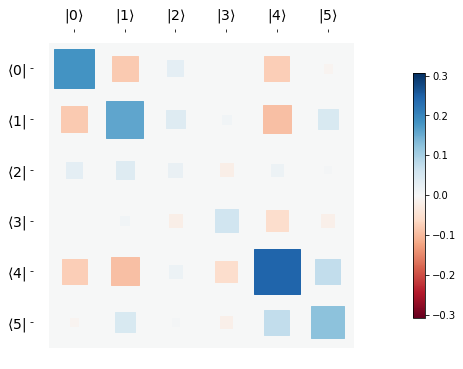

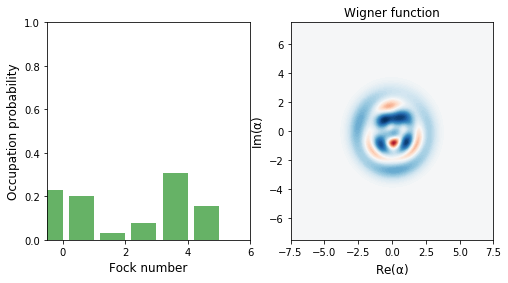

In [65]:
Dim = 6
rho = rand_dm(Dim) #Creates random Dim x Dim density matrix
#rho = qeye(6)
hinton(rho)
plot_wigner_fock_distribution(rho);

In [0]:
#Setup system

a = destroy(N) 
H = a.dag()*a     # Simple harmonic oscillator Hamiltonian
psi0=basis(N,1) # Initial Fock state with one photon
kappa=1.0/0.129 # Coupling rate to heat bath; k=0 means no decay, 
#k=1 means linear decay
nth= 0.063      # Temperature with <n> = 0.063

# Build collapse operators for the thermal bath
c_ops = []
c_ops.append(np.sqrt(kappa * (1 + nth)) * a)
c_ops.append(np.sqrt(kappa * nth) * a.dag())



In [112]:
ntraj = [1,10,100,1000] # number of Monte Carlo trajectories
tlist = np.linspace(0,0.8,100)
mc = mcsolve(H,psi0,tlist,c_ops,[H],ntraj) #Monte Carlo solver
me = mesolve(H,psi0,tlist,c_ops, [H]) #Actual solution

10.0%. Run time:   0.94s. Est. time left: 00:00:00:08
20.0%. Run time:   1.80s. Est. time left: 00:00:00:07
30.0%. Run time:   2.49s. Est. time left: 00:00:00:05
40.0%. Run time:   3.11s. Est. time left: 00:00:00:04
50.0%. Run time:   3.71s. Est. time left: 00:00:00:03
60.0%. Run time:   4.33s. Est. time left: 00:00:00:02
70.0%. Run time:   4.95s. Est. time left: 00:00:00:02
80.0%. Run time:   5.59s. Est. time left: 00:00:00:01
90.0%. Run time:   6.19s. Est. time left: 00:00:00:00
Total run time:   6.80s


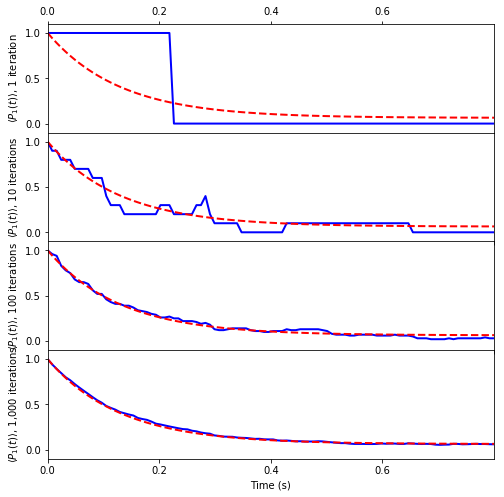

In [128]:


fig = plt.figure(figsize=(8, 8), frameon=False)
plt.subplots_adjust(hspace=0.0)


ax1 = plt.subplot(4,1,1)
ax1.xaxis.tick_top()
ax1.plot(tlist,mc.expect[0][0],'b',lw=2)
ax1.plot(tlist,me.expect[0],'r--',lw=2)
ax1.set_xticks([0,0.2,0.4,0.6])
ax1.set_yticks([0,0.5,1])
ax1.set_xlim([0,0.8])
ax1.set_ylim([-0.1,1.1])
ax1.set_ylabel(r'$\langle P_{1}(t)\rangle$' + ", 1 iteration")




ax2 = plt.subplot(4,1,2)
ax2.plot(tlist,mc.expect[1][0],'b',lw=2)
ax2.plot(tlist,me.expect[0],'r--',lw=2)
ax2.set_xlim([0,0.8])
ax2.set_yticks([0,0.5,1])
ax2.set_ylim([-0.1,1.1])
ax2.set_ylabel(r'$\langle P_{1}(t)\rangle$' + ", 10 iterations")


ax3 = plt.subplot(4,1,3)
ax3.plot(tlist,mc.expect[2][0],'b',lw=2)
ax3.plot(tlist,me.expect[0],'r--',lw=2)
ax3.set_xlim([0,0.8])
ax3.set_yticks([0,0.5,1])
ax3.set_ylim([-0.1,1.1])
ax3.set_ylabel(r'$\langle P_{1}(t)\rangle$' + ", 100 iterations")


ax4 = plt.subplot(4,1,4)
ax4.plot(tlist,mc.expect[3][0],'b',lw=2)
ax4.plot(tlist,me.expect[0],'r--',lw=2)
plt.xticks([0,0.2,0.4,0.6])
plt.yticks([0,0.5,1])
ax4.set_xlim([0,0.8])
ax4.set_ylim([-0.1,1.1])
ax4.set_xlabel(r'Time (s)')
ax4.set_ylabel(r'$\langle P_{1}(t)\rangle$' + ", 1,000 iterations")

xticklabels = ax2.get_xticklabels()+ax3.get_xticklabels()
plt.setp(xticklabels, visible=False);



### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

I installed Qutip, a library for doing quantum physics in Python. I played around with its basic functions and also worked with using Latex in iPython, a markup language to display math. Finally, working off an example, I made a simulation of a photon decaying many times and showed how the averaged results matched with theory.

2.  What was the most challenging part of what you did?

The most challenging part was trying to understand the underlying physics.

3.  What was the most interesting thing you learned?

It was nice to see how easily certain problems can be tackled with this library, since my experience with Python math libraries is that they can be a little fiddly.

4.  What area would you like to explore with more time?

I would like to see if it is possible to do Latex markup as a direct output of code cells.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.